# Heat Kernel Score

This notebook provides further visualization of both the Euclidean and ${\rm SU}(2)$ Heat evolution using the heat kernel and its score function. This notebook contains no machine learning, just numerical integration to simulate the heat equation.

## Setup

In [1]:
# General imports
import torch
import numpy as np
import itertools

import tqdm.auto as tqdm
import matplotlib.pyplot as plt

In [2]:
import sun_diffusion

from sun_diffusion.utils import grab, wrap
from sun_diffusion.devices import set_device, get_device, summary

from sun_diffusion.linalg import trace, adjoint
from sun_diffusion.sun import proj_to_algebra, mat_angle
from sun_diffusion.heat import (
    eucl_log_hk, eucl_score_hk,
    sun_hk, sun_score_hk, sun_score_hk_autograd
)

In [3]:
# Set a device
import sun_diffusion.devices as devices  # from our sun_diffusion code

devices.set_device('cpu')
print(devices.summary())

Using device: cpu (CPU) with dtype: torch.float64


## Visualize the Euclidean heat kernel and its score function

  0%|          | 0/100 [00:00<?, ?it/s]

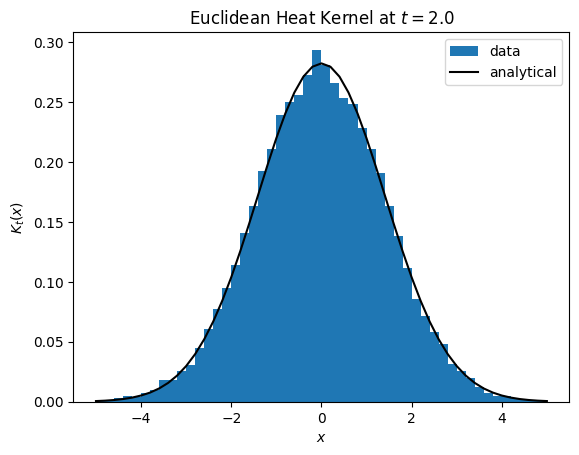

In [4]:
def _test_eucl_hk():
    # forward diffusion
    batch_size = 16000
    x = torch.zeros((batch_size, 1))
    t = 2.0
    sigma = np.sqrt(t)
    steps = 100
    dt = t/steps
    for _ in tqdm.tqdm(range(steps)):
        x += np.sqrt(dt) * torch.randn_like(x)
    x = grab(x)
    
    # analytical
    x_mesh = torch.linspace(-5, 5, steps=51)[...,None]
    hk = torch.exp(eucl_log_hk(x_mesh, width=sigma))
    x_mesh = grab(x_mesh)
    hk = grab(hk)
    hk /= np.sum(hk) * (x_mesh[1]-x_mesh[0])
    
    # plot
    fig, ax = plt.subplots(1, 1)
    bins = np.linspace(-5, 5, num=51)
    ax.hist(x, bins=bins, density=True, label='data')
    ax.plot(x_mesh, hk, color='k', label='analytical')
    ax.legend()
    ax.set_title(f'Euclidean Heat Kernel at $t = {t}$')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$K_t(x)$')
    plt.show()


_test_eucl_hk()

  0%|          | 0/100 [00:00<?, ?it/s]

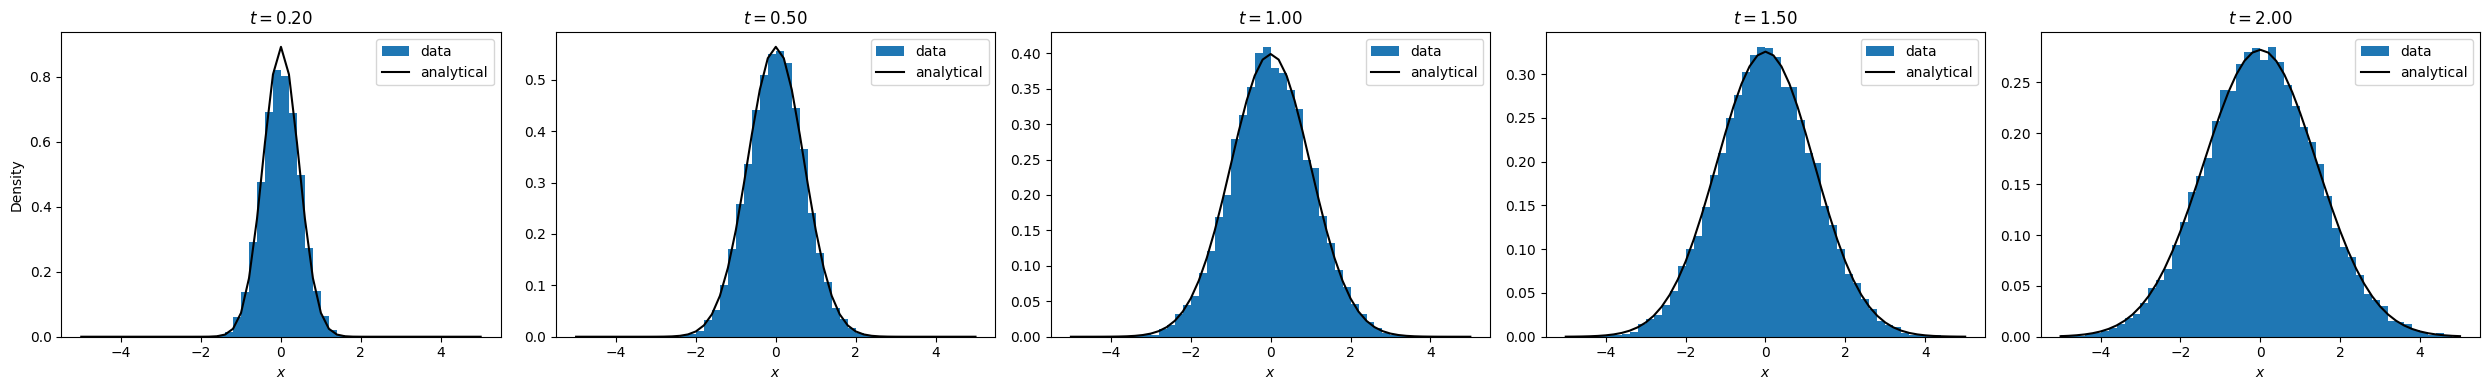

In [5]:
def _test_eucl_hk_evolution():
    batch_size = 16000
    steps = 100
    t_final = 2.0
    dt = t_final / steps
    times_to_plot = [0.2, 0.5, 1.0, 1.5, 2.0]  # intermediate times

    # prepare subplot
    fig, axes = plt.subplots(1, len(times_to_plot), figsize=(5 * len(times_to_plot), 4))

    x = torch.zeros((batch_size, 1))  # initial data at t=0
    x_mesh = torch.linspace(-5, 5, 51)[..., None]

    t_current = 0.0
    step_idx = 0
    for step in tqdm.tqdm(range(steps)):
        x += np.sqrt(dt) * torch.randn_like(x)
        t_current += dt
        if step_idx < len(times_to_plot) and t_current >= times_to_plot[step_idx]:
            sigma = np.sqrt(times_to_plot[step_idx])

            # analytical
            hk = torch.exp(eucl_log_hk(x_mesh, width=sigma))
            hk = grab(hk)
            hk /= np.sum(hk) * (x_mesh[1]-x_mesh[0])
            x_plot = grab(x)

            # plot
            ax = axes[step_idx]
            bins = np.linspace(-5, 5, num=51)
            ax.hist(x_plot, bins=bins, density=True, label='data')
            ax.plot(grab(x_mesh), hk, color='k', label='analytical')
            ax.set_title(f'$t = {times_to_plot[step_idx]:.2f}$')
            ax.set_xlabel('$x$')
            ax.legend()

            step_idx += 1
    axes[0].set_ylabel('Density')
    plt.tight_layout()
    plt.show()


_test_eucl_hk_evolution()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

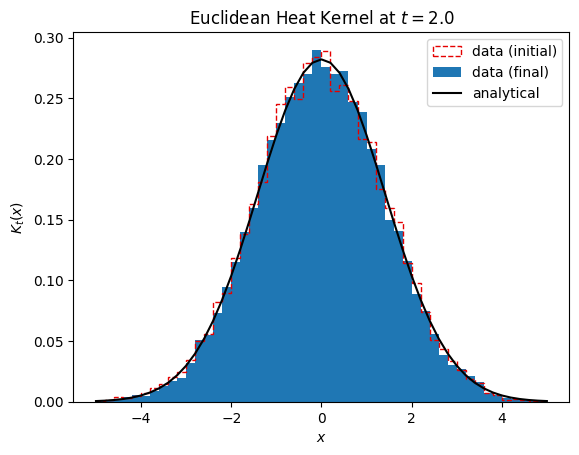

In [6]:
def _test_eucl_score():
    # forward diffusion
    batch_size = 16000
    x = torch.zeros((batch_size, 1))
    t = 2.0
    sigma = np.sqrt(t)
    steps = 1000
    dt = t/steps
    for _ in tqdm.tqdm(range(steps)):
        x += np.sqrt(dt) * torch.randn_like(x)
    x_pre = np.copy(grab(x))
    
    # stationary diffusion
    for _ in tqdm.tqdm(range(steps)):
        g = eucl_score_hk(x, width=sigma)
        x += np.sqrt(dt) * torch.randn_like(x) + 0.5*dt * g
    x = grab(x)
    
    # analytical
    x_mesh = torch.linspace(-5, 5, steps=51)[...,None]
    hk = torch.exp(eucl_log_hk(x_mesh, width=sigma))
    x_mesh = grab(x_mesh)
    hk = grab(hk)
    hk /= np.sum(hk) * (x_mesh[1]-x_mesh[0])
    
    # plot
    fig, ax = plt.subplots(1, 1)
    bins = np.linspace(-5, 5, num=51)
    ax.hist(x_pre, bins=bins, density=True, label='data (initial)', histtype='step', color='xkcd:red', linestyle='--')
    ax.hist(x, bins=bins, density=True, label='data (final)')
    ax.plot(x_mesh, hk, color='k', label='analytical')
    ax.legend()
    ax.set_title(f'Euclidean Heat Kernel at $t = {t}$')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$K_t(x)$')
    plt.show()


_test_eucl_score()

  0%|          | 0/1000 [00:00<?, ?it/s]

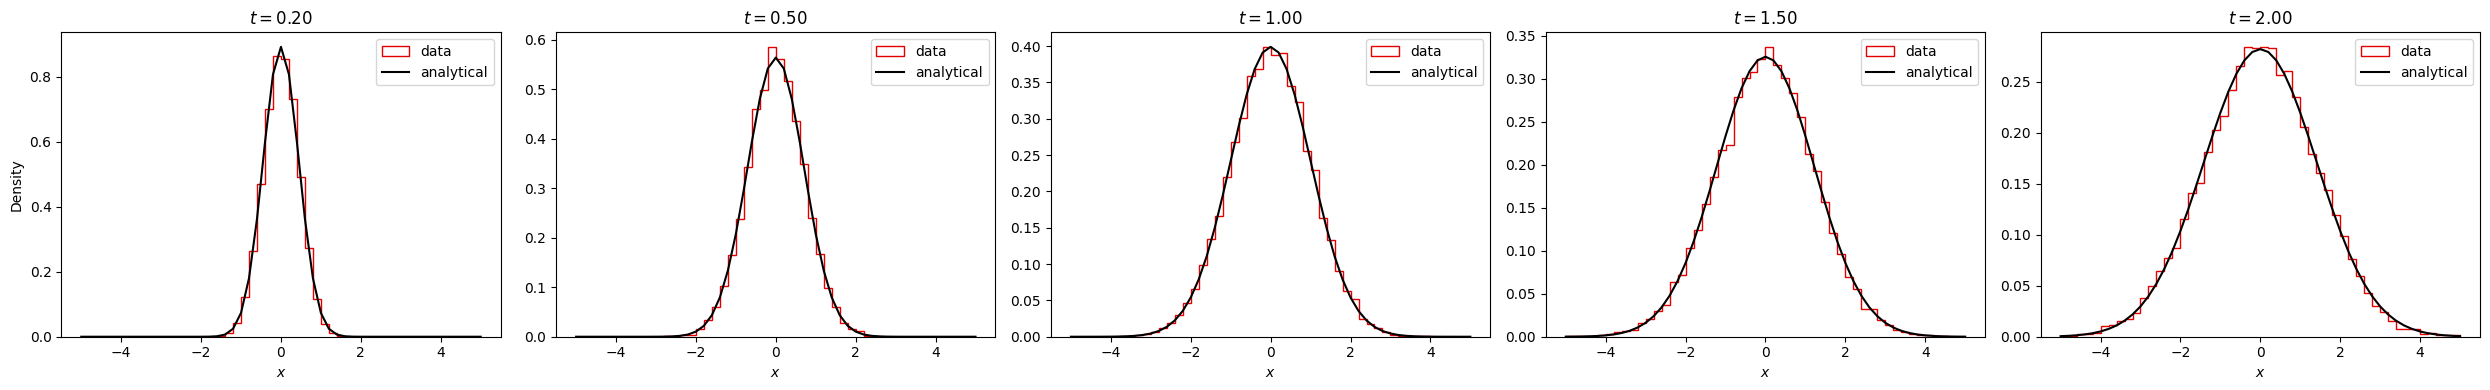

In [7]:
def _test_eucl_score_evolution():
    batch_size = 16000
    steps = 1000
    t_final = 2.0
    dt = t_final / steps
    times_to_plot = [0.2, 0.5, 1.0, 1.5, 2.0]

    # prepare subplot
    fig, axes = plt.subplots(1, len(times_to_plot), figsize=(5 * len(times_to_plot), 4))

    x = torch.zeros((batch_size, 1))
    x_mesh = torch.linspace(-5, 5, 51)[..., None]

    t_current = 0.0
    step_idx = 0
    for step in tqdm.tqdm(range(steps)):
        # forward diffusion
        x += np.sqrt(dt) * torch.randn_like(x)

        t_current += dt
        if step_idx < len(times_to_plot) and t_current >= times_to_plot[step_idx]:
            sigma = np.sqrt(times_to_plot[step_idx])

            # stationary diffusion step (Euler-Maruyama using score)
            g = eucl_score_hk(x, width=sigma)
            x_step = x + 0.5 * dt * g  # only drift, not adding extra noise for clarity
            x_plot = grab(x_step)

            # analytical density
            hk = torch.exp(eucl_log_hk(x_mesh, width=sigma))
            hk = grab(hk)
            hk /= np.sum(hk) * (x_mesh[1] - x_mesh[0])

            # plot
            ax = axes[step_idx]
            bins = np.linspace(-5, 5, num=51)
            ax.hist(x_plot, bins=bins, density=True, label='data', histtype='step', color='xkcd:red')
            ax.plot(grab(x_mesh), hk, color='k', label='analytical')
            ax.set_title(f'$t = {times_to_plot[step_idx]:.2f}$')
            ax.set_xlabel('$x$')
            ax.legend()

            step_idx += 1

    axes[0].set_ylabel('Density')
    plt.tight_layout()
    plt.show()

_test_eucl_score_evolution()

## The ${\rm SU}(N)$ Heat kernel and its score function

In [8]:
def sample_sun_gaussian(shape):
    Nc, Nc_ = shape[-2:]
    assert Nc == Nc_
    return proj_to_algebra(torch.randn(shape) + 1j*torch.randn(shape))

  0%|          | 0/500 [00:00<?, ?it/s]

hk=tensor([3.2937e-23, 1.5740e-02, 6.2465e-02, 1.3871e-01, 2.4209e-01, 3.6940e-01,
        5.1674e-01, 6.7963e-01, 8.5322e-01, 1.0324e+00, 1.2121e+00, 1.3872e+00,
        1.5531e+00, 1.7055e+00, 1.8407e+00, 1.9557e+00, 2.0480e+00, 2.1161e+00,
        2.1592e+00, 2.1771e+00, 2.1706e+00, 2.1408e+00, 2.0895e+00, 2.0190e+00,
        1.9316e+00, 1.8303e+00, 1.7179e+00, 1.5973e+00, 1.4713e+00, 1.3426e+00,
        1.2136e+00, 1.0867e+00, 9.6364e-01, 8.4605e-01, 7.3518e-01, 6.3199e-01,
        5.3712e-01, 4.5092e-01, 3.7352e-01, 3.0483e-01, 2.4458e-01, 1.9237e-01,
        1.4772e-01, 1.1009e-01, 7.8906e-02, 5.3615e-02, 3.3701e-02, 1.8708e-02,
        8.2614e-03, 2.0831e-03, 5.1031e-07])


/u/octavio5/projects/sun_diffusion/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


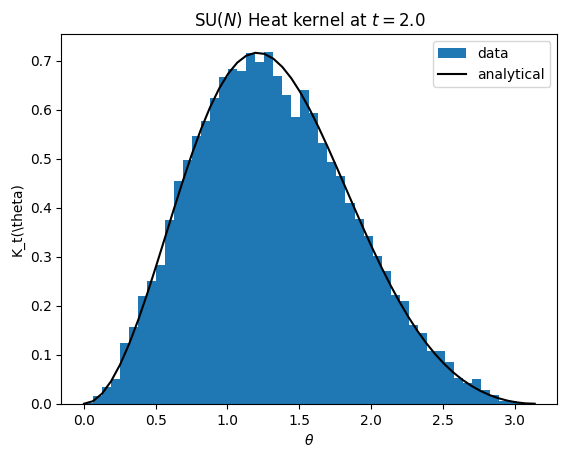

In [9]:
def _test_sun_hk():
    # forward diffusion
    batch_size = 16000
    Nc = 2
    x = torch.stack([torch.eye(Nc)]*batch_size).cdouble()
    t = 2.0
    sigma = np.sqrt(t)
    steps = 500
    dt = t/steps
    for _ in tqdm.tqdm(range(steps)):
        x = torch.matrix_exp(1j * np.sqrt(dt) * sample_sun_gaussian(x.shape)) @ x
    x = grab(torch.arccos(trace(x)/2)) # get canonical cell angle
    
    # analytical
    x_mesh = torch.linspace(0, np.pi-1e-3, steps=51)[...,None]
    hk = sun_hk(x_mesh, width=sigma)
    print(f'{hk=}')
    x_mesh = grab(x_mesh)
    hk = grab(hk)
    hk /= np.sum(hk) * (x_mesh[1]-x_mesh[0])
    
    # plot
    fig, ax = plt.subplots(1, 1)
    bins = np.linspace(0, np.pi, num=51)
    ax.hist(x, bins=bins, density=True, label='data')
    ax.plot(x_mesh, hk, color='k', label='analytical')
    ax.legend()
    ax.set_title(rf'${{\rm SU}}(N)$ Heat kernel at $t = {t}$')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'K_t(\theta)')
    plt.show()


_test_sun_hk()

  0%|          | 0/500 [00:00<?, ?it/s]

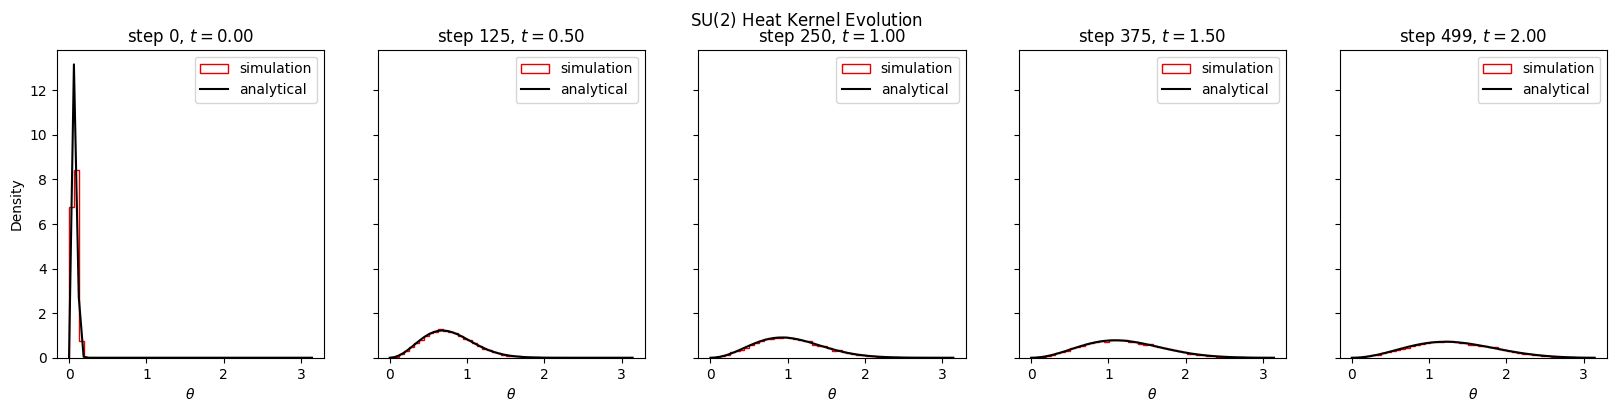

In [10]:
def _test_sun_hk_evolution():
    batch_size = 16000
    Nc = 2
    x = torch.stack([torch.eye(Nc)]*batch_size).cdouble()
    t = 2.0
    steps = 500
    dt = t / steps
    snapshot_steps = [0, int(steps*0.25), int(steps*0.5), int(steps*0.75), steps-1]
    snapshots = []
    sigmas = []

    # forward diffusion
    for i in tqdm.tqdm(range(steps)):
        x = torch.matrix_exp(1j * np.sqrt(dt) * sample_sun_gaussian(x.shape)) @ x
        if i in snapshot_steps:
            angles = torch.arccos(torch.real(trace(x)/Nc))  # canonical eigenangle
            snapshots.append(grab(angles))
            sigmas.append(np.sqrt(dt*(i+1)))


    n_snap = len(snapshots)
    fig, axes = plt.subplots(1, n_snap, figsize=(4*n_snap, 4), sharey=True)
    for ax, angles, sigma, step in zip(axes, snapshots, sigmas, snapshot_steps):
        # compute analytical heat kernel at this sigma
        x_mesh = torch.linspace(0, np.pi-1e-3, steps=51)[...,None]
        bins = np.linspace(0, np.pi, num=51)
        hk = sun_hk(x_mesh, width=sigma)
        x_mesh = grab(x_mesh)
        hk = grab(hk)
        hk /= np.sum(hk) * (x_mesh[1]-x_mesh[0])

        ax.hist(angles, bins=bins, density=True, histtype='step', color='xkcd:red', label='simulation')
        ax.plot(x_mesh, hk, color='k', label='analytical')
        ax.set_title(f'step {step}, $t={dt*step:.2f}$')
        ax.set_xlabel(r'$\theta$')
        ax.legend()

    axes[0].set_ylabel('Density')
    fig.suptitle(r'${\rm SU}(2)$ Heat Kernel Evolution')
    plt.show()


_test_sun_hk_evolution()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

hk=tensor([3.2937e-23, 1.5740e-02, 6.2465e-02, 1.3871e-01, 2.4209e-01, 3.6940e-01,
        5.1674e-01, 6.7963e-01, 8.5322e-01, 1.0324e+00, 1.2121e+00, 1.3872e+00,
        1.5531e+00, 1.7055e+00, 1.8407e+00, 1.9557e+00, 2.0480e+00, 2.1161e+00,
        2.1592e+00, 2.1771e+00, 2.1706e+00, 2.1408e+00, 2.0895e+00, 2.0190e+00,
        1.9316e+00, 1.8303e+00, 1.7179e+00, 1.5973e+00, 1.4713e+00, 1.3426e+00,
        1.2136e+00, 1.0867e+00, 9.6364e-01, 8.4605e-01, 7.3518e-01, 6.3199e-01,
        5.3712e-01, 4.5092e-01, 3.7352e-01, 3.0483e-01, 2.4458e-01, 1.9237e-01,
        1.4772e-01, 1.1009e-01, 7.8906e-02, 5.3615e-02, 3.3701e-02, 1.8708e-02,
        8.2614e-03, 2.0831e-03, 5.1031e-07])


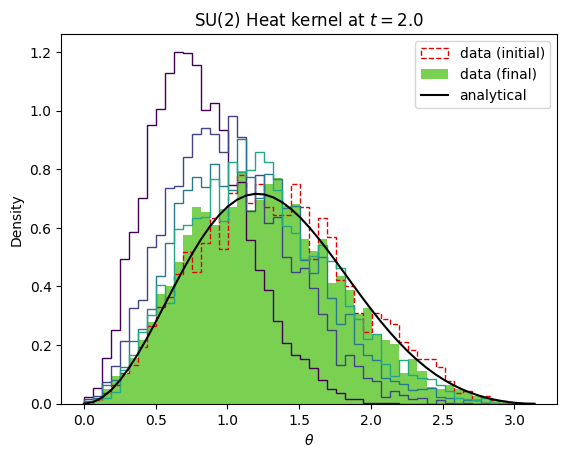

In [11]:
def _test_sun_score():
    # forward diffusion
    batch_size = 4096
    Nc = 2
    x = torch.stack([torch.eye(Nc)]*batch_size).cdouble()
    t = 2.0
    sigma = np.sqrt(t)
    steps = 500
    dt = t/steps
    for _ in tqdm.tqdm(range(steps)):
        x = torch.matrix_exp(1j * np.sqrt(dt) * sample_sun_gaussian(x.shape)) @ x
    x_pre = grab(torch.arccos(trace(x)/2))
    
    # stationary diffusion
    x = torch.matrix_exp(0.1j * sample_sun_gaussian(x.shape))
    t2 = 3.0
    steps = 500
    dt = t2/steps
    xt = []
    for i in tqdm.tqdm(range(steps)):
        thetas, V, Vinv = mat_angle(x)
        g = sun_score_hk(thetas[...,:-1], width=sigma)
        assert torch.allclose(g.sum(-1), torch.tensor(0.0).to(g)), \
            f'{g.sum(-1)=}'
        thetas += 0.5 * dt * g
        D = torch.exp(1j * thetas)[...,None] * torch.eye(Nc).to(thetas)
        x = V @ D @ Vinv
        x = torch.matrix_exp(1j * np.sqrt(dt) * sample_sun_gaussian(x.shape)) @ x
        if (i+1) % 100 == 0:
            xt.append(grab(torch.arccos(trace(x)/2)))
    
    # analytical
    x_mesh = torch.linspace(0, np.pi-1e-3, steps=51)[...,None]
    hk = sun_hk(x_mesh, width=sigma)
    print(f'{hk=}')
    x_mesh = grab(x_mesh)
    hk = grab(hk)
    hk /= np.sum(hk) * (x_mesh[1] - x_mesh[0])
    
    # plot
    fig, ax = plt.subplots(1, 1)
    bins = np.linspace(0, np.pi, num=51)
    ax.hist(x_pre, bins=bins, density=True, label='data (initial)', histtype='step', color='xkcd:red', linestyle='--')
    cmap = plt.get_cmap('viridis')
    for i,x in enumerate(xt):
        style = dict(histtype='step', color=cmap(i/len(xt)))
        if i == len(xt)-1:
            style['label'] = 'data (final)'
            style['histtype'] = 'bar'
        ax.hist(x, bins=bins, density=True, **style)
    ax.plot(x_mesh, hk, color='k', label='analytical')
    ax.legend()
    ax.set_title(rf'${{\rm SU}}({Nc})$ Heat kernel at $t = {t}$')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel('Density')
    plt.show()


_test_sun_score()